# 2. RL Agent

In this tutorial, we introduce an overview of RL Agent.

This tutorial provides instructions on how to initialize the agent, how to interact with the environment, and overview of learning architecture.

## Initialization

The `create_sac_agent` function is used to initialize the agent. This function takes `observation_space`, `action_space`,`model_config`,`key` as arguments and returns the model corresponding to the argument.

The `create_sac_agent` function has a common interface for continuous and discrete, so users can create the environment they wish to experiment with and then create the corresponding model.

It is also possible to LOAD the parameters of the trained model to the initialized agent. 


In [42]:
import hydra
import jax
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from flax.training import checkpoints
from jaxman.env.env import JaxMANEnv
from jaxman.planner.rl_planner.agent.sac.sac import create_sac_agent

env_config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/env/random.yaml"))
env_config.is_discrete=False
env_config.num_agents=8
env_config.map_size=128
model_config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/model/sac.yaml"))
env = JaxMANEnv(env_config)
env.reset()

observation_space = env.observation_space
action_space = env.action_space

# Initialized model
key = jax.random.PRNGKey(0)
actor, critic, target_critic, temp, key = create_sac_agent(
    observation_space,
    action_space,
    model_config,
    key,
)

# load pretrained model parameters
actor = checkpoints.restore_checkpoint(ckpt_dir="../model/", target=actor, prefix="continuous_actor")

## Interact with Environment
Unlike most reinforcement learning libraries, our library does not recommend that agent-environment interactions be based on object-based designs such as the following
```python
# Example of object-based agent-env interaction
while done:
    actions = actor.sample(observations)
    observations, rewards, done, info = env.step(actions)
```

The main reason for not using object-based interaction is that the above structure does not improve the speed of interaction.
In `Jax`, execution speed can be increased by precompiling functions. However, this cannot be achieved with an object-based design. 

We recommend a functional language oriented interaction method to significantly improve the speed of interactions.

(-0.5, 999.5, 999.5, -0.5)

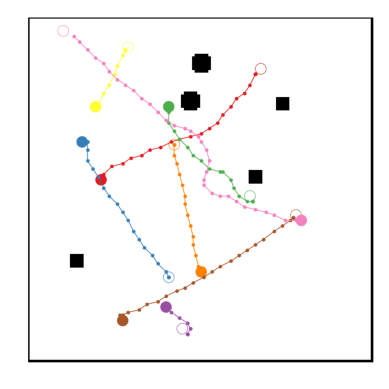

In [41]:
from jaxman.planner.rl_planner.rollout.rollout import build_rollout_episode

# compile rollout episode function
rollout_fn = build_rollout_episode(env.instance, actor.apply_fn, evaluate=True)
# rollout episode
carry = rollout_fn(key, actor.params, env.instance.obs)

# check agent rollout trajectories
steps = carry.episode_steps
task_info = carry.task_info
state_traj = carry.experience.observations[:steps, :, :5]
env.reset(task_info = task_info)
plt.imshow(env.render(state_traj = state_traj))
plt.axis("off")

As shown above, the interaction between the agent and the environment can be easily compiled. 

It is also easy to run rollout, automatically generating a task by giving a random number `key`, parameters of the actor `actor.params`, and information about obstacles `env.instance.obs`, and calculating the information until the end of the episode. 

Information about the episodes is in the `carry`, and it is also possible to check the contents of the episodes. In particular, trajectory information needed for agent training is stored in `carry.experience`.

## Training

To train agents, we employ a distributed learning structure. Distributed learning is composed of the three components below.
- `rollout worker`: rollout episode and push agent experience to `global buffer`
- `global buffer`: recieve agent experience and store it. sample `train_batch` and send it to `learner`
- `learner`: training agent network

Such a distributed structure is based on A-pex, see `scripts/train_rl.py` or [A-pex paper](https://arxiv.org/pdf/1803.00933.pdf) for details.